In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
store = pd.read_csv('Data/store.csv')
train_1 = pd.read_csv('Data/train_1.csv', low_memory=False)
train_2 = pd.read_csv('Data/train_2.csv', low_memory=False)
train = pd.concat([train_1, train_2], axis=0)
train= train.drop(columns=['Unnamed: 0']).reset_index(drop = True)

print('store : ',store.shape)
print('train : ',train.shape)

store :  (1115, 10)
train :  (1017209, 9)


In [4]:
train = train.drop(train[train.Open == 0].index)

In [7]:
train["Date"] = pd.to_datetime(train["Date"], format="%Y-%m-%d")
train["StateHoliday"] = train["StateHoliday"].astype("str")
date_threshold = train["Date"].max() - pd.DateOffset(weeks=6)
aux = train.apply(
    lambda row: {"Date_Day" : row["Date"].day,
                 "Date_Month" : row["Date"].month,
                 "Date_Year" : row["Date"].year,
                 "Date_Week" : row["Date"].week},
    axis = 1,
    result_type='expand')

In [10]:
train = pd.concat([train,aux], axis=1)
X_train = train.loc[train["Date"] < date_threshold].drop(columns=["Open", "Sales", "Customers"]).reset_index(drop=True)
Y_train = train.loc[train["Date"] < date_threshold, "Sales"].reset_index(drop=True)
X_test = train.loc[train["Date"] >= date_threshold].drop(columns=["Open", "Sales", "Customers"]).reset_index(drop=True)
Y_test = train.loc[train["Date"] >= date_threshold, "Sales"].reset_index(drop=True)

In [12]:
ct = ColumnTransformer(
    [("PassThrough", "passthrough", [
        'Store','Promo','DayOfWeek', 'Date_Week', 'Date_Year']),
    ])

pipe_RF = Pipeline([('ColumnTransformer', ct),
                    ('RFRegressor', RandomForestRegressor())])

In [13]:
pipe_RF.fit(X_train, Y_train)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(transformers=[('PassThrough', 'passthrough',
                                                  ['Store', 'Promo',
                                                   'DayOfWeek', 'Date_Week',
                                                   'Date_Year'])])),
                ('RFRegressor', RandomForestRegressor())])

In [20]:
Y_train_pred_RF = pipe_RF.predict(X_train)
Y_test_pred_RF = pipe_RF.predict(X_test)

In [25]:
print('RMSE Train :',mean_squared_error(Y_train_pred_RF , Y_train, squared = False)**0.5)
print('RMSE Test :',mean_squared_error(Y_test_pred_RF , Y_test, squared = False)**0.5)

RMSE Train : 24.173467375036637
RMSE Test : 35.836547406686


In [26]:
importances = pipe_RF["RFRegressor"].feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(pipe_RF['ColumnTransformer'].get_feature_names())

# Print the feature ranking
n = len(feature_names)
print("Feature ranking:")

for f in range(n):
    print("Feature name : {},\tFeature importance:{}%".format(feature_names[indices[f]],
                                                             round(100*importances[indices[f]]),2))

Feature ranking:
Feature name : Store,	Feature importance:69.0%
Feature name : Promo,	Feature importance:13.0%
Feature name : Date_Week,	Feature importance:9.0%
Feature name : DayOfWeek,	Feature importance:7.0%
Feature name : Date_Year,	Feature importance:2.0%


In [27]:
print(feature_names)

['Store' 'Promo' 'DayOfWeek' 'Date_Week' 'Date_Year']


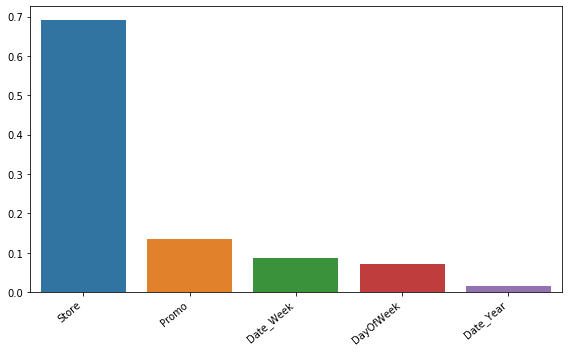

In [28]:
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(8,5)) 
ax=sns.barplot(x=feature_names[indices], y=importances[indices])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")  #it will rotate text on x axis

plt.tight_layout()
plt.show()

In [39]:
df = X_test[["Store", "Date"]]
df["Predicted_Sales"] = pipe_RF.predict(X_test)
df["Real_Sales"] = Y_test

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
df["err_rel"] = np.abs((df["Predicted_Sales"] - df["Real_Sales"])) / df["Real_Sales"]
df.head(3)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Store,Date,Predicted_Sales,Real_Sales,err_rel
0,1,2015-07-31,5400.17,5263,0.026063
1,2,2015-07-31,5590.97,6064,0.078006
2,3,2015-07-31,7897.03,8314,0.050153


In [43]:
df_err_store = store[["Store", "StoreType"]]

df_err_store["rmse"] = df_err_store.apply(
    lambda row : mean_squared_error(
        df.loc[df["Store"] == row["Store"],"Real_Sales"],
        df.loc[df["Store"] == row["Store"],"Predicted_Sales"],
        squared = False),
    axis = 1
)
df_err_store["mean_sales"] = df_err_store.apply(
    lambda row : df.loc[df["Store"] == row["Store"],"Real_Sales"].mean(),
    axis = 1
)
df_err_store.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Store,StoreType,rmse,mean_sales
0,1,c,718.794142,4387.027027
1,2,a,802.740600,4944.216216
2,3,a,1128.743065,6870.000000
3,4,c,1455.548565,9983.189189
4,5,a,772.525867,4510.945946


In [44]:
df_err_store.shape

(1115, 4)

In [47]:
df_err_date = pd.DataFrame(
    data = {"Date" : df["Date"].unique()}
)

df_err_date["rmse"] = df_err_date.apply(
    lambda row : mean_squared_error(
        df.loc[df["Date"] == row["Date"],"Real_Sales"],
        df.loc[df["Date"] == row["Date"],"Predicted_Sales"],
        squared = False),
    axis = 1
)

df_err_date["mean_sales"] = df_err_date.apply(
    lambda row : df.loc[df["Date"] == row["Date"],"Real_Sales"].mean(),
    axis = 1
)
df_err_date.head()

,Date,rmse,mean_sales
0,2015-07-31,2329.770782,9083.326146
1,2015-07-30,1627.452984,7905.529200
2,2015-07-29,1370.669045,7636.982929
3,2015-07-28,1047.049728,8189.643306
4,2015-07-27,1945.073174,9620.208446


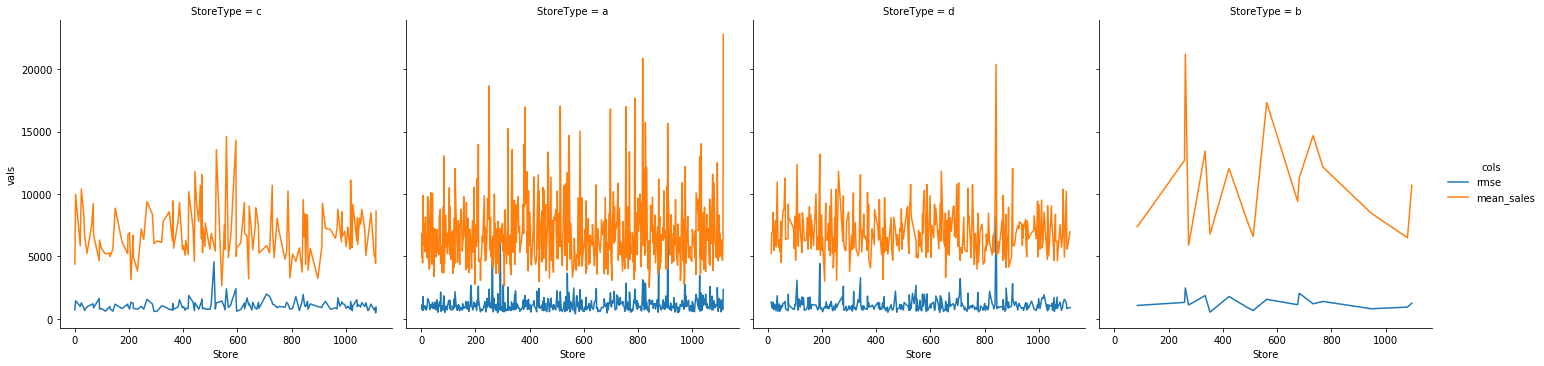

In [48]:
t = df_err_store.melt(['Store', "StoreType"], var_name='cols',  value_name='vals')     

sns.relplot(
    x="Store",
    y="vals",
    hue='cols',
    col='StoreType',
    kind="line",
    data=t)

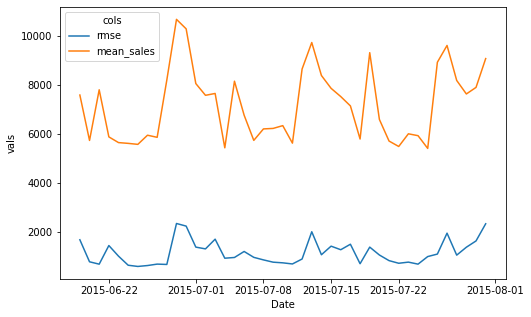

In [49]:
t = df_err_date.melt('Date', var_name='cols',  value_name='vals')     

plt.figure(figsize=(8,5)) 
sns.lineplot(
    x="Date",
    y="vals",
    hue='cols',
    data=t)

In [51]:
df_err_date
df_err_date.melt('Date', var_name='cols',  value_name='vals')   

,Date,cols,vals
0,2015-07-31,rmse,2329.770782
1,2015-07-30,rmse,1627.452984
2,2015-07-29,rmse,1370.669045
3,2015-07-28,rmse,1047.049728
4,2015-07-27,rmse,1945.073174
...,...,...,...
81,2015-06-23,mean_sales,5648.448833
82,2015-06-22,mean_sales,5881.991023
83,2015-06-21,mean_sales,7807.781250
84,2015-06-20,mean_sales,5736.679533


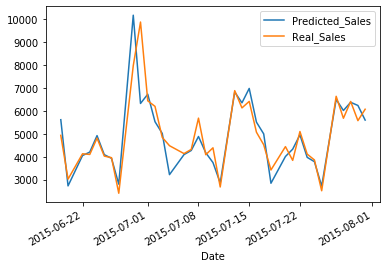

In [52]:
#Zoom on one particular store
df.loc[df["Store"] == 2].plot(x="Date", y=["Predicted_Sales", "Real_Sales"])

In [53]:
test = X_test.copy()
test["Predicted_Sales"] = pipe_RF.predict(X_test)
test["Real Sales"] = Y_test
merged_test = pd.merge(test, store, on='Store', how='inner')

In [54]:
merged_test.to_csv("./prediction.csv")